# Completion Trie and metrics

Evaluation of a completion system on wikpedia pages.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Wikipedia titles, uniform

In [ ]:
from mlstatpy.data.wikipedia import download_titles
file_titles = download_titles(country='fr')

In [ ]:
from mlstatpy.data.wikipedia import enumerate_titles
list_titles = list(sorted(set(_ for _ in enumerate_titles(file_titles) if 'A' <= _[0] <= 'Z')))

In [ ]:
len(list_titles), list_titles[:5], list_titles[1000000:1000005]

(3108490,
 ['A',
  'A & A',
  'A (Airport Express)',
  'A (Ayumi Hamasaki)',
  "A (Disque d'Ayumi Hamasaki)"],
 ['Fantasy in the sky',
  'Fantasy mythique',
  'Fantasy of manners',
  'Fantasy tennis',
  'Fantasy urbaine'])

In [ ]:
from mlstatpy.nlp.completion import CompletionTrieNode

def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(w * len(q) for q, w in zip(queries, weights))
    res = []
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w)-trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w)-trie.min_dynamic_keystroke(w)[0]) for p, w in per]
    wks_dyn2 = [(w, p, len(w)-trie.min_dynamic_keystroke2(w)[0]) for p, w in per]
    gain = sum( g*p/total for w, p, g in wks)
    gain_dyn = sum( g*p/total for w, p, g in wks_dyn)
    gain_dyn2 = sum( g*p/total for w, p, g in wks_dyn2)
    ave_length = sum( len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

In [ ]:
import time, random, pandas

def benchmark(sizes):
    print("time", 0)
    allres = []
    for size in sizes:
        begin = time.clock()
        if size is None:
            size = len(list_titles)
            spl = list_titles
        else:
            spl = random.sample(list_titles, size)
        spl.sort()
        res = gain_dynamique_moyen_par_mot(spl, [1.0] * len(spl))
        dt = time.clock() - begin
        print("time: {0}s - nb={1}".format(dt, len(spl)), "gain", tuple(_/res[-1] for _ in res))
        allres.append((size, dt) + res)
        # with open("sample%d.txt" % len(spl), "w", encoding="utf-8") as f:
        #    f.write("\n".join(spl))
    df = pandas.DataFrame(allres, columns="size time mks mks' mks\" ave_len".split())    
    for c in "mks mks' mks\"".split():
        df["%" + c] = df[c] / df["ave_len"]
        df[c + "/mks"] = df[c] / df["mks"]    
    return df
                  
df = benchmark([200, 500, 800, 1000, 2000, 5000, 8000, 10000, 20000])
df.tail(n=2)

time 0
time: 0.20192674470119548s - nb=200 gain (0.8293988805062059, 0.8293988805062059, 0.8293988805062059, 1.0)
time: 0.5796266076874788s - nb=500 gain (0.7931251309997901, 0.7931251309997901, 0.7931251309997901, 1.0)
time: 0.9751951290853949s - nb=800 gain (0.7785362651788669, 0.7785362651788669, 0.7785362651788669, 1.0)
time: 1.1925940750547797s - nb=1000 gain (0.7767432342558958, 0.7767432342558958, 0.7767432342558958, 1.0)
time: 2.2563879865825767s - nb=2000 gain (0.7508178286648957, 0.7508178286648957, 0.7508178286648957, 1.0)
time: 5.926565522833054s - nb=5000 gain (0.7162774810582523, 0.7162774810582523, 0.7162774810582523, 1.0)
time: 10.053861272328875s - nb=8000 gain (0.6993765991794295, 0.6993893607110686, 0.6993893607110686, 1.0)
time: 12.098951785198071s - nb=10000 gain (0.6884742668617938, 0.6884742668617938, 0.6884742668617938, 1.0)
time: 26.640322743421713s - nb=20000 gain (0.6550705331387788, 0.6550834916430565, 0.6550834916430565, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
7,10000,12.098952,0.688474,0.688474,0.688474,1.0,0.688474,1.0,0.688474,1.00000,0.688474,1.00000
8,20000,26.640323,0.655071,0.655083,0.655083,1.0,0.655071,1.0,0.655083,1.00002,0.655083,1.00002


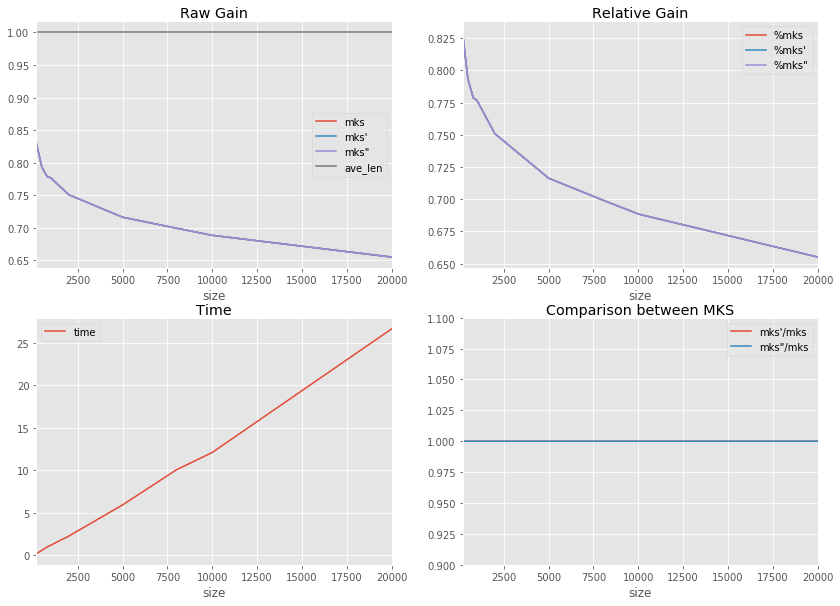

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2, 2, figsize=(14,10))
df.plot(x="size", y="time", ax=ax[1,0])
df.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
df.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
df.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")

## Reduce the alphabet size

In [ ]:
from mlstatpy.data.wikipedia import enumerate_titles
list_titles = list(sorted(set(_ for _ in enumerate_titles(file_titles) if 'A' <= _[0] <= 'Z')))

In [ ]:
import time, random, pandas

def char_modulo(c, size):
    if len(c) != 1:
        raise Exception("unexpected size '%s'" % c)
    if len(c) != len(c.lower()):
        raise Exception("unexpected lower size '%s' != '%s' (%d != %d)" % (c, c.lower(), len(c), len(c.lower())))
    if size is None:
        return c
    else:
        cl = c.lower()
        if len(cl) > len(c):
            cl = c
        o = ord(cl)
        a = 97
        d = (o - a) + size * 10
        return chr(97  + (d % size))

def reduce_alphabet(sample, size):
    return ["".join(char_modulo(c, size) for c in word) for word in sample]

def benchmark_size(size, alphabet_sizes):
    if size is None:
        size = len(list_titles)
        sample = list_titles
    else:
        sample = random.sample(list_titles, size)
    print("time", 0)
    allres = []
    for size in alphabet_sizes:
        begin = time.clock()
        spl = reduce_alphabet(sample, size)
        spl = list(sorted(set(spl)))
        res = gain_dynamique_moyen_par_mot(spl, [1.0] * len(spl))
        dt = time.clock() - begin
        print("time: {0}s - nb={1}".format(dt, len(spl)), "gain", tuple(_/res[-1] for _ in res))
        if size is None:
            size = max(_ for _ in alphabet_sizes if _ is not None) + 5
        allres.append((size, dt) + res)
        # with open("sample%d.txt" % len(spl), "w", encoding="utf-8") as f:
        #    f.write("\n".join(spl))
    df = pandas.DataFrame(allres, columns="size time mks mks' mks\" ave_len".split())    
    for c in "mks mks' mks\"".split():
        df["%" + c] = df[c] / df["ave_len"]
        df[c + "/mks"] = df[c] / df["mks"]    
    return df
                  
df = benchmark_size(5000, [None] + list(range(2, 26)))
df.tail(n=2)

time 0
time: 7.658914529783033s - nb=5000 gain (0.7160915298025441, 0.7160915298025441, 0.7160915298025441, 1.0)
time: 3.8636799044834333s - nb=4566 gain (0.4165915430220072, 0.43859835187564, 0.43859835187564, 1.0)
time: 5.042899747354568s - nb=4946 gain (0.5568410876630024, 0.5599572174914604, 0.5599572174914604, 1.0)
time: 5.669480493933406s - nb=4974 gain (0.5978123555692509, 0.603389308272994, 0.603389308272994, 1.0)
time: 5.421274843357423s - nb=4994 gain (0.6368866918280266, 0.6394712011814894, 0.6394712011814894, 1.0)
time: 5.653578521175405s - nb=4994 gain (0.6463661076063022, 0.6468687490383176, 0.6468687490383176, 1.0)
time: 5.635773580129353s - nb=4996 gain (0.6649540569365775, 0.6649745672327462, 0.6649745672327462, 1.0)
time: 5.622856060334016s - nb=4998 gain (0.6708675143560342, 0.6711238720262557, 0.6711238720262557, 1.0)
time: 5.83437889680863s - nb=4996 gain (0.6840701883928701, 0.6841112102472631, 0.6841112102472631, 1.0)
time: 6.167061372223543s - nb=4999 gain (0.68

,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
23,24,6.454003,0.712125,0.712125,0.712125,1.0,0.712125,1.0,0.712125,1.0,0.712125,1.0
24,25,6.253289,0.713150,0.713150,0.713150,1.0,0.713150,1.0,0.713150,1.0,0.713150,1.0


In [ ]:
df = df.sort_values("size")

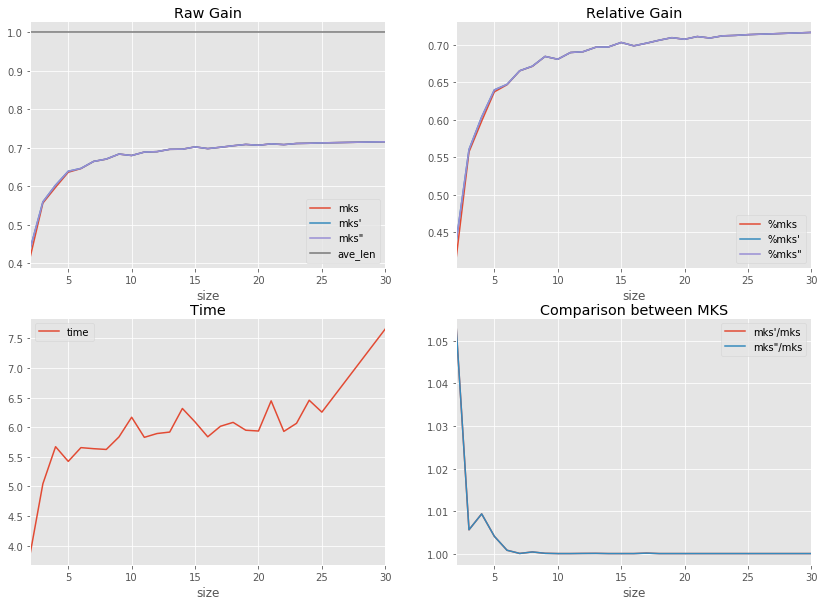

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2, 2, figsize=(14,10))
df.plot(x="size", y="time", ax=ax[1,0])
df.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
df.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
df.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
#ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")

## Wikipedia titles, uniform, longer test

In [ ]:
df2 = benchmark([50000])
df2.tail(n=2)

time 0
time: 51.593102616602664s - nb=50000 gain (0.6156778731975445, 0.6159606490730745, 0.6159606490730745, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
0,50000,51.593103,0.615678,0.615961,0.615961,1.0,0.615678,1.0,0.615961,1.000459,0.615961,1.000459


In [ ]:
df2 = benchmark([50000, 100000, 200000]) # , 500000, 500000, 1000000, 2000000, None]) too long in python
df2.tail(n=2)

time 0
time: 51.71647568562457s - nb=50000 gain (0.6151853794658116, 0.6153694347560206, 0.6153694347560206, 1.0)
time: 97.28684360423085s - nb=100000 gain (0.5825927598123372, 0.5830375907791329, 0.5830375907791329, 1.0)
time: 189.68798033913026s - nb=200000 gain (0.549685488715713, 0.5509044430706759, 0.5509044430706759, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
1,100000,97.286844,0.582593,0.583038,0.583038,1.0,0.582593,1.0,0.583038,1.000764,0.583038,1.000764
2,200000,189.687980,0.549685,0.550904,0.550904,1.0,0.549685,1.0,0.550904,1.002218,0.550904,1.002218


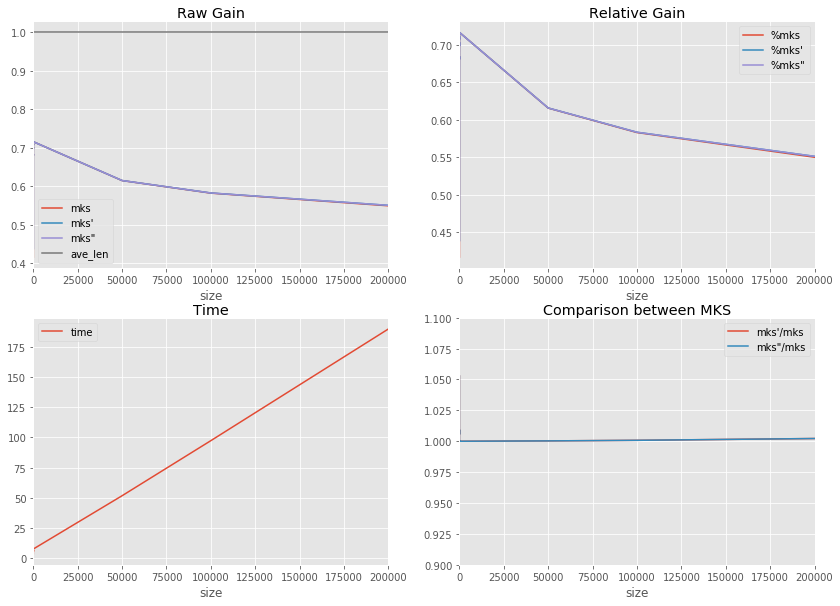

In [ ]:
dfall = pandas.concat([df, df2])
f, ax = plt.subplots(2, 2, figsize=(14,10))
dfall.plot(x="size", y="time", ax=ax[1,0])
dfall.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
dfall.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
dfall.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")